In [2]:
import os


In [3]:
! pwd

/


In [4]:
! pip install transformers

In [5]:
import transformers

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
transformers.logging.set_verbosity_info

<function transformers.utils.logging.set_verbosity_info()>

In [7]:
import re
from tqdm import tqdm
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [9]:
device

device(type='cuda')

In [10]:
torch.cuda.is_available()  #GPU가 torch 캐치 가능 

True

In [11]:
torch.cuda.get_device_name(0)  #지금 잡은 device뭔지 보여줌 

'NVIDIA GeForce RTX 4090'

In [12]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")
model = AutoModelForSequenceClassification.from_pretrained("klue/bert-base", num_labels=5)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at klue/bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
type(tokenizer), type(model)

(transformers.models.bert.tokenization_bert_fast.BertTokenizerFast,
 transformers.models.bert.modeling_bert.BertForSequenceClassification)

In [14]:
torch.cuda.empty_cache()

In [15]:
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

**언어모델 및 Tokenizer 불러오기**

**데이터셋 가져오기**

In [16]:
data_path = "/root/merged_df_4000.csv"
data = pd.read_csv(data_path)
data.head()

,Unnamed: 0,class,conversation
0,0,일반 대화,휴일이니...쉬게해주세요내말이 ... ㅜㅜ 너무 가기 싫어
1,1,일반 대화,물고기 잡아 올리는 것도 할 수 있어?하하 응 그게 묘미더라 물고기 잡혔을 때 ㅎ/...
2,2,기타 괴롭힘 대화,야 이새끼 봐바 오타쿠인가봐\n 뭔데뭔데 아 뭐냐 그림. 이게 그 미미쨩인가 그거냐...
3,3,일반 대화,"그랬는데, 내가 몰래 여사친 만나다가 여자친구한테 걸려서... 여자친구가 울면서 헤..."
4,4,기타 괴롭힘 대화,야.근데.이렇게 하는거 맞아.???\n맞다고 병신아!!\n야 근데 왜 자꾸 욕해.?...


In [17]:
# class 대화 라벨링하기

data['class'].unique()
class_labels = {"협박 대화":0, "기타 괴롭힘 대화":1, "갈취 대화": 2, "직장 내 괴롭힘 대화":3, "일반 대화": 4}
data['label'] = data['class'].map(class_labels)

In [18]:
data.head()

,Unnamed: 0,class,conversation,label
0,0,일반 대화,휴일이니...쉬게해주세요내말이 ... ㅜㅜ 너무 가기 싫어,4
1,1,일반 대화,물고기 잡아 올리는 것도 할 수 있어?하하 응 그게 묘미더라 물고기 잡혔을 때 ㅎ/...,4
2,2,기타 괴롭힘 대화,야 이새끼 봐바 오타쿠인가봐\n 뭔데뭔데 아 뭐냐 그림. 이게 그 미미쨩인가 그거냐...,1
3,3,일반 대화,"그랬는데, 내가 몰래 여사친 만나다가 여자친구한테 걸려서... 여자친구가 울면서 헤...",4
4,4,기타 괴롭힘 대화,야.근데.이렇게 하는거 맞아.???\n맞다고 병신아!!\n야 근데 왜 자꾸 욕해.?...,1


여기서 작은 모델만 training 하는 거니까 len 작게만...0.1만 뽑겠당.

In [19]:
len(data)

7950

In [20]:
# new_data_path = os.path.join(os.getenv('HOME'), "aiffel/dktc/test (2).csv")
# new_data = pd.read_csv(new_data_path)

In [21]:
# new_data.head()

In [22]:
# test_data = new_data['text'].tolist()

In [23]:
sampled_data = data
sampled_data['conversation'] = sampled_data['conversation'].str.replace('\n', " ")


In [24]:
sampled_data['conversation'] = sampled_data['conversation'].str.replace('nan', "")


In [25]:
(sampled_data['conversation'].str.startswith('nan') == True).count()

np.int64(7950)

In [26]:
sampled_data['conversation'][7402]

nan

In [27]:
sampled_data.drop(7402, inplace=True)

In [28]:
sampled_data['conversation'].dropna(inplace=True)
len(sampled_data)

7949

In [29]:
sampled_data['label'].value_counts()

label
4    3999
1    1094
2     981
3     979
0     896
Name: count, dtype: int64

In [30]:
#결측치 확인
sampled_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7949 entries, 0 to 7949
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0    7949 non-null   int64 
 1   class         7949 non-null   object
 2   conversation  7949 non-null   object
 3   label         7949 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 310.5+ KB


In [31]:
#중복값 확인
sampled_data[sampled_data['conversation'].duplicated()]


,Unnamed: 0,class,conversation,label
1329,1329,기타 괴롭힘 대화,야 쟤 걷는것좀 봐 왜저러냐? 나보고 하는 소리야? 여기에 너 말고 더 있냐? 뒤뚱...,1
1339,1339,기타 괴롭힘 대화,야 너 이리 와봐 저요? 그래 너 여기 살아? 네? 왜요? 제일 맛있는데 좀 추천해...,1
1502,1502,기타 괴롭힘 대화,저기 재수없는 년 지나간다 나한테그런거야? 응 너 전부터 보기도 싫었어 그냥 왜그래...,1
1547,1547,기타 괴롭힘 대화,넌 목소리가 왜 그래? 듣기 싫어. 나도 내 목소리가 가끔 듣기 싫더라. 듣기 싫으...,1
1552,1552,협박 대화,저번에 말한 물건들 준비됐어? 아니 선생님. 시간을 조금만 더 주세요. 저번에도 그...,0
...,...,...,...,...
7757,7757,기타 괴롭힘 대화,너 홍길동이랑 사귄다며 응 맞아 니가 어울린다고 생각해 웃겨 정말 왜 그래 내가 홍...,1
7802,7802,기타 괴롭힘 대화,너가 쓴글 다 구라아님? 진짠데. 증명해봐. 어떻게 믿냐? 인터넷이라 신상털려서 안...,1
7827,7827,기타 괴롭힘 대화,공책 돌려받길 원하면 빨리 뛰어봐. 이 굼벵아. 빨리 내놔. 빨릐 내놔아. 빨리 내...,1
7907,7907,기타 괴롭힘 대화,야 니 왤캐 못생겼냐? 뭐라그랬냐? 으 나 보고 말하지마 니 얼굴보면 토나올거 같어...,1


In [32]:
#중복값 제거
#sampled_data.drop_duplicates(subset = ['conversation'], inpla
# ce = True)

In [33]:
# def remove_null_conversations(dataframe):
#     # 'conversation_split' 열의 null 값 찾기
#     null_conversations = dataframe[dataframe['conversation_split'].isnull()]

#     # null 값이 있는지 확인하고, 있다면 해당 행 제거
#     if not null_conversations.empty:
#         dataframe = dataframe.dropna(subset=['conversation_split'])

#     return dataframe

# 함수 호출
cleaned_data = sampled_data

# # 결과 확인
# cleaned_data['label'].value_counts()

## BERT 불러오기

In [34]:
X_data = cleaned_data['conversation']
y_data = cleaned_data['label']

In [35]:
TEST_SIZE = 0.2 # Train: Test = 8 :2 분리
RANDOM_STATE = 2024
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data,
                                                    test_size = TEST_SIZE,
                                                    random_state = RANDOM_STATE,
                                                    stratify = y_data)  #stratify하면 데이터 분리 이전의 라벨별 비율을 고려해 데이터 분리

In [36]:
X_train

1828        무슨 소리야 나 네 시부터 접속해 있었는데뭐지... 분명 너 온라인 안 떠 있던데
2986    야 문 열어 문 안여냐!! 아.너네가 여기 까지는 뭔 일이야.? 우리집에는 왜 왔어...
7586    야 나 오늘 소개팅 갈건데 니 시계 좀 빌줘 봐 이 시계는 많이 비싼데. 못 빌려줄...
2949    응응 엑소가 마블 세계관 베꼈잖아 ㅋㅋ아 맞네 ㅋㅋ 예전에 그 기사 본 것 같아 ㅋ...
4968    컵밥도 종류가 다양해서 먹을 거 꽤 많던데 컵밥은 어때?컵밥 좋지/이제 주말인데 저...
                              ...                        
918     지현씨 나 소개팅 좀 시켜줘봐 네? 저 주변에 아는 사람이 없어서요 아 상사라 불편...
5926    감독님 저 더 이상 시나리오 못짜겠습니다. 대신 그동안 작업해놨는 것을 이어서 다른...
7916    항상 생각하는건데 너 진짜 못생겼다 또 왜 그래.저번에도 그만 하라고 했잖아. 아니...
2128    잘지냈지 그동안 장기 잘 보관하고 있었겠지? 응 장기는 여기 이번이 내가 보관하는 ...
4977                     vr기기같은것이 활성화되면 가능하지 않을까?vr체험해봤니?
Name: conversation, Length: 6359, dtype: object

In [37]:
X_train_list = X_train.tolist()
X_test_list = X_test.tolist()
y_train_list = y_train.tolist()
y_test_list = y_test.tolist()

In [38]:
print(type(X_train_list))

<class 'list'>


In [39]:
dic = {0: "협박 대화", 1:"기타 괴롭힘 대화", 2:"갈취 대화", 3:"직장 내 괴롭힘 대화", 4:"일반 대화"}
ans_train = torch.tensor(y_train_list)

In [40]:
ans_train

tensor([4, 2, 2,  ..., 1, 0, 4])

In [41]:
def create_batches(input_list, output_list, batch_size):
  assert len(input_list) == len(output_list)
  for i in range(0, len(input_list), batch_size):
        yield (input_list[i:i + batch_size], output_list[i:i + batch_size])

BATCH_SIZE = 64  # You can adjust this as needed

In [42]:
# 런타임 1분 소요
# 활성화 함수 AdamW 불러오기
from transformers import AdamW

# 활성화 함수 AdamW 인스턴스화
optimizer = AdamW(model.parameters(), lr=0.00001)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [42]:
%%time
# 모델을 학습 모드로 변경
model.train()

# 에포크 수 지정 및 손실을 담은 빈 컨테이너 리스트 생성
epochs = 10
losses = []

# 파인튜닝
for epoch in range(epochs):
    temp = []
    for batch, labels in create_batches(X_train_list, ans_train, BATCH_SIZE):
        inputs = tokenizer.batch_encode_plus(batch, return_tensors="pt", padding=True, truncation=True).to(device)
        labels = labels.to(device)
        
        # 그래디언트(기울기) 초기화
        optimizer.zero_grad()
        # 변수 eval_list에 담긴 여섯 개 문장을 토크나이저에 넣고 인코딩
        #inputs = tokenizer.batch_encode_plus(X_train_list, return_tensors="pt", padding=True, truncation=True)
        # 위에서 생성된 input 변수에 담긴 키(key)와 키값(value)을 **inputs 형식(**kwargs 형식)으로 모델에 전달
        # 거기에 추가로 labels를 텐서 타입으로 모델에 전달
        outputs = model(**inputs, labels=labels)
        # 로짓 추출
        logits = outputs.logits
        
        # print(outputs.loss)
        # break
    
        # 손실 추출
        loss = outputs.loss
        
        # 오차역전파
        loss.backward()

        # 가중치(weight) 업데이트
        optimizer.step()

        # 손실을 빈 컨테이너 losses에 순서대로 저장
        temp.append(loss)

        # 에포크 및 손실 값 출력

    # 에폭당 평균 손실 계산 및 출력
    avg_epoch_loss = sum(temp) / len(temp)
    print(f"epoch:{epoch+1}, average loss:{avg_epoch_loss}")
    losses.append(avg_epoch_loss)

epoch:1, average loss:0.6688998937606812
epoch:2, average loss:0.20762771368026733
epoch:3, average loss:0.1137077808380127
epoch:4, average loss:0.07027722150087357
epoch:5, average loss:0.053214266896247864
epoch:6, average loss:0.05505817383527756
epoch:7, average loss:0.03072524443268776
epoch:8, average loss:0.023290840908885002
epoch:9, average loss:0.017765551805496216
epoch:10, average loss:0.009686054661870003
CPU times: user 2min 55s, sys: 3min 5s, total: 6min
Wall time: 5min 41s


In [43]:
new_losses = [i.item() for i in losses]
print(new_losses)

[0.6688998937606812, 0.20762771368026733, 0.1137077808380127, 0.07027722150087357, 0.053214266896247864, 0.05505817383527756, 0.03072524443268776, 0.023290840908885002, 0.017765551805496216, 0.009686054661870003]


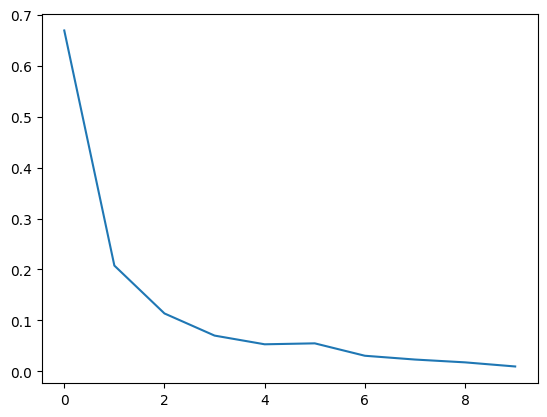

In [44]:
import matplotlib.pyplot as plt
plt.plot(new_losses);


In [45]:
# 파인 튜닝 이후 추론
# 모델을 eval 모델로 전환
model.eval()

# 모델 예측을 담을 preds라는 빈 컨테이너 리스트 생성
preds = []

# 이하 코드의 설명은 문제 45 코드 참조
with torch.no_grad():
  for sentence in X_test_list:
    inputs = tokenizer.encode(sentence, return_tensors="pt",padding=True, truncation=True)
    inputs = inputs.to(device)
    outputs = model(inputs)
    logits = outputs.logits
    pred = logits.argmax(-1).item()
    logits = logits.detach().cpu().numpy()
    preds.append(logits.argmax(-1).item())
    print(f"{dic[pred]}:{sentence}")



기타 괴롭힘 대화:이 음식 왜 이렇게 맛이 없어요? 짜서 못 먹겠네 네 죄송합니다 고객님 다시 만들어 드릴께요 아니 됐어요 짜다고 하시니 다시 만들어드릴께요 이 실력이면 또 만들어도 짜지 거의 다 드셨는데 일찍 말씀해주시지. 맛없는거 참고 먹었어요 아.네 이거 저는 계산 못하겠어요 손님.
일반 대화:뭐야 ㅋㅋ 같이 해야지 왜 너혼자 하고 있어ㅋㅋ 나 돈도 많이 벌어서 가축도 많이 샀어
협박 대화:야 이자식 명품입었네? 벗어봐. 나도 사려고하던건데 입어만보자 네.? 저 이거 벗으면 맨몸이에요 내꺼 입어봐 자식아. 너랑 나랑 바꿔입는게 더 잘 어울리네 고맙다 임마 왜 그러세요. 돌려주세요. 선물받은 겁니다. 선물이고 나발이고. 니네 가족들도 좋은거 많이 입고 들고댕기더라? 니네 동생이 집에들어가는 시간이 매번 8시 쯤이더라? 구경가도되냐? 동생 건드리지마십쇼. 누가 건드린다그래? 친해지고 싶은거지. 나도 좋은 옷입고 좋은 거 들고 다니는 애들이랑 친해져보자. 이옷 가지시고 그만해주세요. 누굴 거지로봐? 얘봐라. 누굴 거지로 보네. 죽고싶냐? 그런 거 아닙니다. 제발 부탁드립니다.
일반 대화:너희 할머니는 연세가 어떻게 돼?지금 75살 되셨어 하하
일반 대화:백신도 지금 문제가 많더라...백신은 맞았어?/다른 나라도 우리나라도 계속 백신으로 힘 쓰는 거 같긴 한데...
일반 대화:그 고통 잘 알지...?알지 두부도 못먹었는 걸 ㅜㅜ ㅋㅋ
일반 대화:응 트럭이랑 승용차라 부딪혔어.다친 사람은 없었어?
일반 대화:그렇다고 비싸게 주고 살 정돈 아니지 마일리지로는 사도마일리지 너 얼마나 있어 대한항공?
일반 대화:참고할게 우리 술찌들은 칵테일 먹으러 한두 번 같 것 같아!오 칵테일 괜찮지 우리는 항상 소주 맥주 ㅋㅋ/한국인이야 아주


일반 대화:언니 축구 좋아해?아니 나 축구는 별로 안 좋아해./축구 말고 배구!/넌 배구 좋아해?
직장 내 괴롭힘 대화:과장님. 말씀하신 기획표 보고드립니다. 세리씨. 이걸 기획표라고 가져오나? 네? 과장님이 말씀하신거 다 넣었는데 문제가 되나요? 폰트가 다르잖아. 글꼴도 이상하고. 그리고 내가 말한건 이게아냐 아니 분명. 말씀하신거 다 넣었습니다. 아니라면 아닌거지. 왜이렇게 말대꾸지? 상사한테 그렇게 대들라고 배웠나? 아니 시키신대로 기획표 작성했고 전 이해가 가질않아서 말씀드리는겁니다. 세리씨는 참 이렇게 대드는게 마음에 안들어. 시키는 일만 할건가? 왜 좀더 창의적이지 못하지? 창의적으로 가져오면 어차피 안보실거잖아요. 내가 이러니 세리씨가 맘에안드는거야. 이사님한테 세리씨의 태도에대해 말해야겠군
기타 괴롭힘 대화:야 신발샀냐? 이쁘네? 응. 엄마가 사줬어. 그건 안 궁금하고 빨리 안 벗냐? 안돼! 생일선물이란말이야! 너희 어머니가 내 생일 선물로 준셈치면되지 안돼! 저번에 빌려간 아이패드도 안줬잖아. 아이패드는 아직도 빌리는 상태인거고 . 이 신발 너보다 내가 더 잘어울릴거같아 제발 그만 가져가.
협박 대화:죽기싫으면 한번 말할때 들으라고 내가 왜 그래야 되는데 아니 잔말말고 하라고 이새끼 안되겠네 감시가 많아서 할수가 없다니까 야 몽둥이 가져와라 다리 하나 부러트려줘? 제발 그만해 일단 죽기전까지 패서 기절시켜 한번만 살려줘. 변명도 못하게 이빨부터 싹 다 뽑아줄게 그럼 내일까지 시간을 좀줘.
일반 대화:난 특이한걸 좋아하거든나도 특이한게 좋음
협박 대화:당장 이 약을 먹어버려 아니면 너희 가족이 위험할꺼야 내가 이거만 먹으면 가족이 살수 있나.? 닥치고 빨리 쳐 먹어 5초 준다. 543.2 잠깐만.! 제발 가족 얼굴 한번만 보게 해줘 그럼 마실께 안되겠구만 다 죽여버려야지 아앗 마실께 기다려 뜸 들이지 말고 확 마셔버리라고 ! 은지야 여보 내가 미안해. 드라마 찍지 말고 얼른 마셔 임마 알겠어. 그래 잘한 선택이야 가족은 살려주지
협박 대화:말같지

In [46]:
ans = torch.tensor(y_test_list)
preds = torch.tensor(preds)
print(f"Accuracy:{100 * sum(ans.detach().clone()==preds)/len(ans.detach().clone())}%")

Accuracy:95.40880584716797%


In [47]:
from sklearn.metrics import f1_score

In [48]:
preds_tensor = torch.tensor(preds).tolist()

# 실제 라벨 (y_test_list)와 예측 라벨 (preds_tensor) 비교하여 F1 Score 계산
f1 = f1_score(y_test_list, preds_tensor, average='weighted')
print(f"F1 Score: {f1}")

F1 Score: 0.9541064001161111


/tmp/ipykernel_10083/2418196024.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds_tensor = torch.tensor(preds).tolist()


In [50]:
type(model)

transformers.models.bert.modeling_bert.BertForSequenceClassification

In [51]:
# model save
model.save_pretrained("/root/ckpt/finetune_kluebert_first", from_pt=True) 


# Inference

In [ ]:
import re
from tqdm import tqdm
import urllib.request
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
                            roc_auc_score, confusion_matrix, classification_report, \
                            matthews_corrcoef, cohen_kappa_score, log_loss
from torch import nn
import torch
from torch.utils.data import Dataset, DataLoader

In [43]:
# model load
model = AutoModelForSequenceClassification.from_pretrained("/root/ckpt/finetune_kluebert_first")
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
# load test.csv


In [ ]:
# evaluation for test and make submission.csv
# 파인 튜닝 이후 추론
# 모델을 eval 모델로 전환
model.eval()

# 모델 예측을 담을 preds라는 빈 컨테이너 리스트 생성
preds = []

# 이하 코드의 설명은 문제 45 코드 참조
with torch.no_grad():
  for sentence in X_test_list:
    inputs = tokenizer.encode(sentence, return_tensors="pt",padding=True, truncation=True)
    inputs = inputs.to(device)
    outputs = model(inputs)
    logits = outputs.logits
    pred = logits.argmax(-1).item()
    logits = logits.detach().cpu().numpy()
    preds.append(logits.argmax(-1).item())
    print(f"{dic[pred]}:{sentence}")

